In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR


class Cutout(object):
    def __init__(self, n_holes=1, length=8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        return img * mask


# Directories for saving plots and histograms
os.makedirs('plots', exist_ok=True)
os.makedirs('histograms', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)


# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    Cutout(n_holes=1, length=8),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# ResNet-18 Model for CIFAR-100
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, 1, stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Mixup utilities
def mixup_data(x, y, alpha=0.1):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam

def mixup_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)


# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
num_epochs = 49
scheduler = OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=num_epochs, pct_start=0.3)


# Training Loop
train_losses, test_losses = [], []
train_accs, test_accs, mixup_alphas = [], [], []

def evaluate(model, dataloader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Fixed missing parenthesis here
            loss_sum += criterion(outputs, targets).item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return loss_sum / total, 100.0 * correct / total

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=0.1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item()
        total_train += targets.size(0)

    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train
    test_loss, test_acc = evaluate(model, testloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    mixup_alphas.append(lam)

    print(f"Epoch [{epoch}/{num_epochs}] Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")


# Plot final accuracy/loss curves
plt.figure()
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend(); plt.title('Accuracy over Epochs'); plt.savefig('plots/accuracy_curve.png')
plt.close()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(); plt.title('Loss over Epochs'); plt.savefig('plots/loss_curve.png')
plt.close()
# Save the trained model
checkpoint_path = 'checkpoints/resnet18_cifar100.pth'
torch.save(model.state_dict(), checkpoint_path)
print(f"✅ Model saved to {checkpoint_path}")

Epoch [1/49] Train Acc: 7.58%, Test Acc: 15.33%
Epoch [2/49] Train Acc: 14.82%, Test Acc: 21.23%
Epoch [3/49] Train Acc: 21.44%, Test Acc: 28.41%
Epoch [4/49] Train Acc: 26.97%, Test Acc: 36.75%
Epoch [5/49] Train Acc: 32.52%, Test Acc: 36.94%
Epoch [6/49] Train Acc: 35.36%, Test Acc: 42.73%
Epoch [7/49] Train Acc: 38.08%, Test Acc: 39.03%
Epoch [8/49] Train Acc: 39.90%, Test Acc: 40.13%
Epoch [9/49] Train Acc: 41.00%, Test Acc: 43.35%
Epoch [10/49] Train Acc: 41.51%, Test Acc: 41.55%
Epoch [11/49] Train Acc: 42.42%, Test Acc: 44.14%
Epoch [12/49] Train Acc: 42.43%, Test Acc: 48.35%
Epoch [13/49] Train Acc: 43.49%, Test Acc: 47.44%
Epoch [14/49] Train Acc: 44.40%, Test Acc: 46.09%
Epoch [15/49] Train Acc: 44.75%, Test Acc: 46.91%
Epoch [16/49] Train Acc: 44.47%, Test Acc: 49.50%
Epoch [17/49] Train Acc: 45.01%, Test Acc: 49.53%
Epoch [18/49] Train Acc: 45.07%, Test Acc: 47.00%
Epoch [19/49] Train Acc: 45.81%, Test Acc: 48.30%
Epoch [20/49] Train Acc: 46.03%, Test Acc: 49.57%
Epoch [21/

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets
from torchvision.utils import save_image

# Load the pretrained model (ResNet18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)  # Assuming you've defined ResNet18 before
checkpoint_path = 'checkpoints/resnet18_cifar100.pth'
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Define the criterion (cross entropy loss)
criterion = nn.CrossEntropyLoss()

# Transformation for the test set (no augmentation, just normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

# Dataset and DataLoader
dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# FGSM Attack Definition
def fgsm_attack(model, image, label, epsilon=0.1):
    image.requires_grad = True  # Enable gradient tracking for the image

    output = model(image)  # Forward pass the image
    loss = criterion(output, label)  # Calculate the loss

    model.zero_grad()  # Clear previous gradients
    loss.backward()  # Backpropagate to compute the gradient of the loss with respect to the image

    data_grad = image.grad.data  # Get the gradients w.r.t image
    perturbed_image = image + epsilon * data_grad.sign()  # Create the adversarial image

    perturbed_image = torch.clamp(perturbed_image, 0, 1)  # Ensure the perturbed image is valid (between 0 and 1)
    return perturbed_image

# Variables for counting and storing results
T = 10000  # Total attempts
N = 0      # Number of adversarial perturbed samples with high confidence
conf_threshold = 0.9  # Confidence threshold for success (90%)

# Loop to generate adversarial examples and check success rate
for i in range(T):
    # Get a real image and its corresponding label from CIFAR-100 test set
    image, label = next(iter(dataloader))
    image, label = image.to(device), label.to(device)

    # Apply FGSM attack
    perturbed_image = fgsm_attack(model, image, label, epsilon=0.1)

    with torch.no_grad():  # No need to track gradients for inference
        output = model(perturbed_image)  # Forward pass the perturbed image
        probs = F.softmax(output, dim=1)  # Get probabilities from the output logits
        max_prob, pred_class = torch.max(probs, dim=1)  # Get the class with highest probability

        if max_prob.item() >= conf_threshold:  # If the model is confident (≥ 90%)
            N += 1
            if N <= 10:  # Save the first 10 adversarial examples for visualization
                save_image(perturbed_image, f"noise_examples/fgsm_{N}_conf_{max_prob.item():.2f}.png")

# Print results
print(f"🔍 Total Attempts (T): {T}")
print(f"✅ Adversarial Perturbed Samples (N): {N}")
print(f"🎯 Success Rate: {(100 * N / T):.2f}%")


🔍 Total Attempts (T): 10000
✅ Adversarial Perturbed Samples (N): 144
🎯 Success Rate: 1.44%


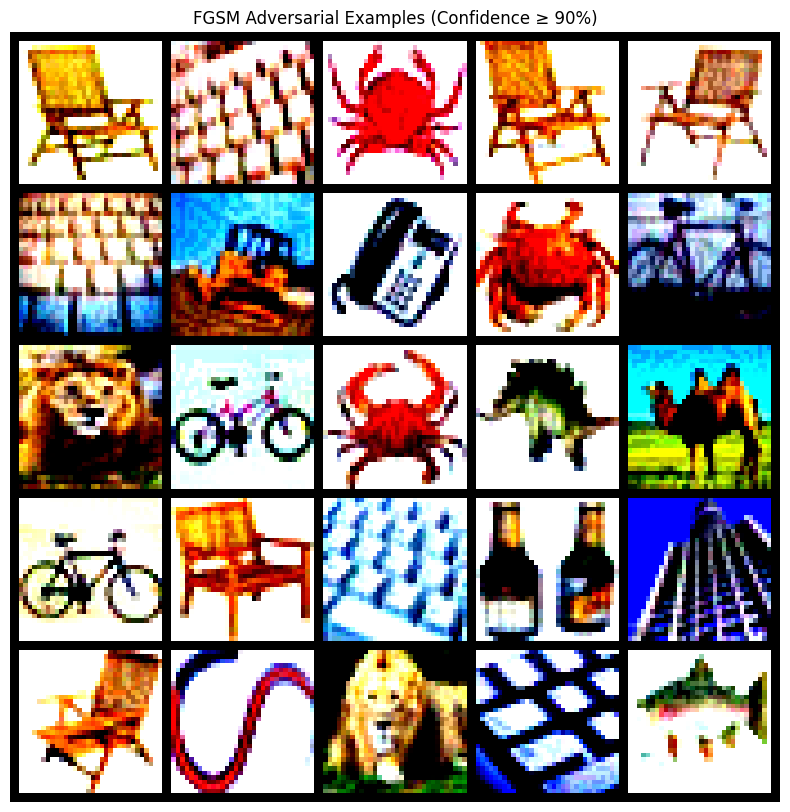

In [21]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Collect up to 25 successful adversarial images and predictions
successful_adv_images = []
successful_adv_preds = []

# Reset dataloader to get fresh images
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

for i, (image, label) in enumerate(dataloader):
    if len(successful_adv_images) >= 25:
        break
    image, label = image.to(device), label.to(device)

    # Apply FGSM attack
    perturbed_image = fgsm_attack(model, image, label, epsilon=0.1)

    with torch.no_grad():
        output = model(perturbed_image)
        probs = F.softmax(output, dim=1)
        max_prob, pred_class = torch.max(probs, dim=1)

        if max_prob.item() >= conf_threshold:
            successful_adv_images.append(perturbed_image.squeeze(0).cpu())
            successful_adv_preds.append((pred_class.item(), max_prob.item()))

# Visualize collected adversarial examples
if successful_adv_images:
    adv_grid = vutils.make_grid(successful_adv_images, nrow=5, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(adv_grid.numpy(), (1, 2, 0)))
    plt.title("FGSM Adversarial Examples (Confidence ≥ 90%)")
    plt.axis("off")
    plt.savefig("plots/fgsm_adversarial_examples_top25.png")
    plt.show()
else:
    print("😔 No high-confidence FGSM adversarial examples found.")


In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.utils import save_image


# Data Augmentation & Preprocessing
class Cutout(object):
    def __init__(self, n_holes=1, length=8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        return img * mask


# Prepare CIFAR-100 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    Cutout(n_holes=1, length=8),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# ResNet-18 model with Spectral Normalization
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False))
        self.conv2 = spectral_norm(nn.Conv2d(planes, planes, 3, 1, 1, bias=False))
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                spectral_norm(nn.Conv2d(in_planes, self.expansion * planes, 1, stride, bias=False))
            )

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        return torch.relu(out)


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = spectral_norm(nn.Conv2d(3, 64, 3, 1, 1, bias=False))
        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Define Loss and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
num_epochs = 49
scheduler = OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=num_epochs, pct_start=0.3)


# Training Loop with Spectral Normalization
def train(model, trainloader, optimizer, scheduler):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(targets).sum().item()
        total_train += targets.size(0)

    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train
    return train_loss, train_acc


# Evaluation Loop
def evaluate(model, testloader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_sum += criterion(outputs, targets).item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return loss_sum / total, 100.0 * correct / total


# Training the Model
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, trainloader, optimizer, scheduler)
    test_loss, test_acc = evaluate(model, testloader)

    print(f"Epoch [{epoch}/{num_epochs}] Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

# Save Model
torch.save(model.state_dict(), "checkpoints/resnet18_cifar100_spectral.pth")
print(f"Model saved to checkpoints/resnet18_cifar100_spectral.pth")


# Implementing FGSM Attack
def fgsm_attack(model, image, label, epsilon=0.1):
    model.eval()
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, label)

    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


# Apply FGSM attack on the model with spectral normalization
dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

T = 10000  # total attempts
N = 0      # adversarial noise examples with confidence ≥ 90%
conf_threshold = 0.9

for i in range(T):
    image, label = next(iter(dataloader))
    image, label = image.to(device), label.to(device)

    perturbed_image = fgsm_attack(model, image, label, epsilon=0.1)

    with torch.no_grad():
        output = model(perturbed_image)
        probs = F.softmax(output, dim=1)
        max_prob, pred_class = torch.max(probs, dim=1)

        if max_prob.item() >= conf_threshold:
            N += 1
            if N <= 10:
                save_image(perturbed_image, f"noise_examples/fgsm_{N}_conf_{max_prob.item():.2f}.png")

print(f"🔍 Total Attempts (T): {T}")
print(f"✅ Adversarial Perturbed Samples (N): {N}")
print(f"🎯 Success Rate: {(100 * N / T):.2f}%")


Epoch [1/49] Train Acc: 1.63%, Test Acc: 2.89%
Epoch [2/49] Train Acc: 3.55%, Test Acc: 4.91%
Epoch [3/49] Train Acc: 5.62%, Test Acc: 8.45%
Epoch [4/49] Train Acc: 7.30%, Test Acc: 11.36%
Epoch [5/49] Train Acc: 9.45%, Test Acc: 13.37%
Epoch [6/49] Train Acc: 11.33%, Test Acc: 16.21%
Epoch [7/49] Train Acc: 12.91%, Test Acc: 16.90%
Epoch [8/49] Train Acc: 14.74%, Test Acc: 19.41%
Epoch [9/49] Train Acc: 16.38%, Test Acc: 20.78%
Epoch [10/49] Train Acc: 17.89%, Test Acc: 23.08%
Epoch [11/49] Train Acc: 19.66%, Test Acc: 23.67%
Epoch [12/49] Train Acc: 21.32%, Test Acc: 26.30%
Epoch [13/49] Train Acc: 22.26%, Test Acc: 27.69%
Epoch [14/49] Train Acc: 23.68%, Test Acc: 27.31%
Epoch [15/49] Train Acc: 24.69%, Test Acc: 31.71%
Epoch [16/49] Train Acc: 25.89%, Test Acc: 33.25%
Epoch [17/49] Train Acc: 27.02%, Test Acc: 32.29%
Epoch [18/49] Train Acc: 27.92%, Test Acc: 35.84%
Epoch [19/49] Train Acc: 28.64%, Test Acc: 34.98%
Epoch [20/49] Train Acc: 29.66%, Test Acc: 35.70%
Epoch [21/49] Tra

In [10]:
def evaluate_on_adversarial_examples(model, dataloader, epsilon=0.1):
    model.eval()
    total, correct = 0, 0
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        # Apply FGSM attack to create adversarial example
        perturbed_image = fgsm_attack(model, image, label, epsilon)

        # Evaluate on the perturbed (adversarial) image
        with torch.no_grad():
            output = model(perturbed_image)
            _, predicted = output.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

    adversarial_accuracy = 100. * correct / total
    print(f"Adversarial Accuracy: {adversarial_accuracy:.2f}%")


In [11]:
evaluate_on_adversarial_examples(model, testloader, epsilon=0.1)


Adversarial Accuracy: 21.17%


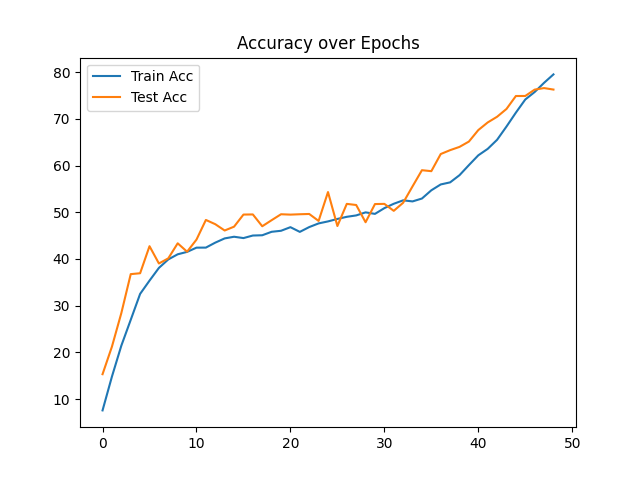

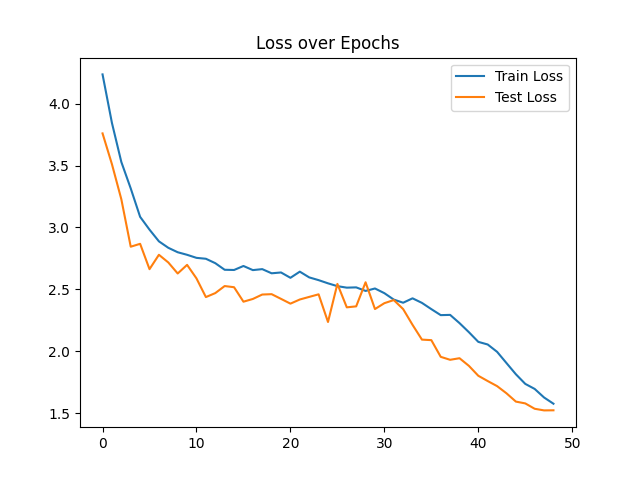

In [13]:
from PIL import Image
from IPython.display import display

display(Image.open("plots/accuracy_curve.png"))
display(Image.open("plots/loss_curve.png"))
